Stats on Ca2+ imaging with miniscope and Spindles

In [257]:
import statsmodels.api as sm
import quantities as pq
import numpy as np
import math 
import neo
import json
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
import pickle
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib widget


In [258]:
# Specify the directory containing the Excel files
directory = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording/"

# Initialize an empty list to store the dataframes
dfs = []
df=[]
dfs2 = []
df2=[]
dfs2_per_sheet = {}
dfs3 = []
df3=[]
dfs3_per_sheet = {}


NrSubtype='L1' # to changed 

if NrSubtype=='L1':
    nametofind='SpindlesPFC_ABdetection_GlobalResultsAB'
    nametofind2='SpindlesPFC_ABdetection_AverageResultsAB'
    nametofind3='SpindlesPFC_ABdetection_AverageSpikeResultsAB'
else:
    nametofind='SpindlesPFC_ABdetection_AllNr_GlobalResultsAB'#for Purple, ThreeColDots and ThreeBlueLines
    nametofind2='SpindlesPFC_ABdetection_AllNr_AverageResultsAB'
    nametofind3='SpindlesPFC_ABdetection_AllNr_AverageSpikeResultsAB'

# Recursively traverse the directory structure
for root, _, files in os.walk(directory):
    for filename in files:
        # Check if the file is an Excel file and contains the specified name
        if filename.endswith('.xlsx') and nametofind in filename: 
            # Construct the full path to the file
            filepath = os.path.join(root, filename)
            # Read the Excel file into a dataframe and append it to the list
            df = pd.read_excel(filepath, index_col=0)
            dfs.append(df)
        if filename.endswith('.xlsx') and nametofind2 in filename: 
            # Construct the full path to the file
            filepath = os.path.join(root, filename)
            # Read the Excel file into a dataframe and append it to the list
            excel_data = pd.read_excel(filepath, sheet_name=None, index_col=0)            
            for sheet_name, df2 in excel_data.items():
                if sheet_name in dfs2_per_sheet:   
                    updated_matrix = np.concatenate([dfs2_per_sheet[sheet_name], df2], axis=0)                    
                    dfs2_per_sheet[sheet_name] = updated_matrix                    
                else:                    
                    dfs2_per_sheet[sheet_name] = df2 #one average trace per unique unit, len(df2)==nb unit recorded for that mouse
        if filename.endswith('.xlsx') and nametofind3 in filename: 
            # Construct the full path to the file
            filepath = os.path.join(root, filename)
            # Read the Excel file into a dataframe and append it to the list
            excel_data = pd.read_excel(filepath, sheet_name=None, index_col=0, header=None)           
            for sheet_name, df3 in excel_data.items():
                if sheet_name in dfs3_per_sheet:   
                    updated_matrix = pd.concat((dfs3_per_sheet[sheet_name],df3), ignore_index=True, axis=0)                
                    dfs3_per_sheet[sheet_name] = updated_matrix                    
                else:                    
                    dfs3_per_sheet[sheet_name] = df3 #one average trace per unique unit, len(df3)==nb unit recorded for that mouse

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(dfs, ignore_index=True)

C:\Users\Manip2\AppData\Local\Temp\ipykernel_42644\1060382287.py:54: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  updated_matrix = pd.concat((dfs3_per_sheet[sheet_name],df3), ignore_index=True, axis=0)
C:\Users\Manip2\AppData\Local\Temp\ipykernel_42644\1060382287.py:54: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  updated_matrix = pd.concat((dfs3_per_sheet[sheet_name],df3), ignore_index=True, axis=0)


In [259]:
unique_count = combined_df['Unique_Unit'].nunique()
print(unique_count, 'units total') # weird that not the same nb as the len of average df2

43 units total


In [260]:
#Remove non defined Unique Units 
combined_df = combined_df[combined_df['Unique_Unit'] != '[]']
combined_df['Unique_Unit'] = combined_df['Unique_Unit'].astype(str)
combined_df['UnitNumber'] = combined_df['UnitNumber'].astype(str)
combined_df['UnitValue'] = combined_df['UnitValue'].astype(str)

In [261]:
combined_df['Unit_ID'] = combined_df['Mice'] + combined_df['Unique_Unit']
combined_df['Spdl_ID'] = combined_df['Mice'] + combined_df['Session'] +combined_df['SpdlNumber'].astype(str)

In [262]:
combined_df

,Mice,Session,Session_Time,Unique_Unit,UnitNumber,UnitValue,SpdlStatut,SpdlNumber,SpdlDuration (ms),SWR inside Spdl,...,CalciumActivityAfter,AUC_calciumBefore,AUC_calciumAfter,SpikeActivityPreference,SpikeActivityBefore,SpikeActivityAfter,AUC_spikeBefore,AUC_spikeAfter,Unit_ID,Spdl_ID
0,BlackLinesOK,session1,NaN,3,0,3,['UnCoupled'],0,1353.0,False,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,BlackLinesOK3,BlackLinesOKsession10
1,BlackLinesOK,session1,NaN,3,0,3,['UnCoupled'],1,813.0,False,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,BlackLinesOK3,BlackLinesOKsession11
2,BlackLinesOK,session1,NaN,3,0,3,['UnCoupled'],2,1032.0,False,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,BlackLinesOK3,BlackLinesOKsession12
3,BlackLinesOK,session1,NaN,3,0,3,['UnCoupled'],3,773.0,False,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,BlackLinesOK3,BlackLinesOKsession13
4,BlackLinesOK,session1,NaN,3,0,3,['UnCoupled'],4,1771.0,False,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,BlackLinesOK3,BlackLinesOKsession14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3118,RedLinesOK,session5,NaN,75,8,108,['UnCoupled'],0,903.0,False,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,RedLinesOK75,RedLinesOKsession50
3119,RedLinesOK,session5,NaN,75,8,108,['PostCoupled'],1,1570.0,True,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,RedLinesOK75,RedLinesOKsession51
3120,RedLinesOK,session5,NaN,75,8,108,['PostCoupled'],2,1058.0,True,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,RedLinesOK75,RedLinesOKsession52
3121,RedLinesOK,session5,NaN,75,8,108,['UnCoupled'],3,1074.0,False,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,RedLinesOK75,RedLinesOKsession53


In [263]:
unique_count = combined_df['Unique_Unit'].nunique()
print(unique_count, 'units total') # weird that not the same nb as the len of average df2
unique_count = combined_df['Spdl_ID'].nunique()
print(unique_count, 'spdl total')

43 units total
445 spdl total


Save big dataset for stats

In [264]:
filenameOut = f'{directory}{NrSubtype}_SpindlesPFC_ABdetection_GrandGlobalAB.xlsx'
writer = pd.ExcelWriter(filenameOut)
combined_df.to_excel(writer)
writer.close()

In [265]:
filenameOut = f'{directory}{NrSubtype}_SpindlesPFC_ABdetection_GrandAverageAB.xlsx'
excel_writer = pd.ExcelWriter(filenameOut)

Array=pd.DataFrame(dfs2_per_sheet['All_Spindles'])
ArrayUn=pd.DataFrame(dfs2_per_sheet['Uncoupled_Spindles'])
ArrayPre=pd.DataFrame(dfs2_per_sheet['Precoupled_Spindles'])
ArrayPost=pd.DataFrame(dfs2_per_sheet['Postcoupled_Spindles'])

Array.to_excel(excel_writer, sheet_name='All_Spindles', index=True, header=False)
ArrayUn.to_excel(excel_writer, sheet_name='Uncoupled_Spindles', index=True, header=False)
ArrayPre.to_excel(excel_writer, sheet_name='Precoupled_Spindles', index=True, header=False)
ArrayPost.to_excel(excel_writer, sheet_name='Postcoupled_Spindles', index=True, header=False)

# Save the Excel file
excel_writer.close()

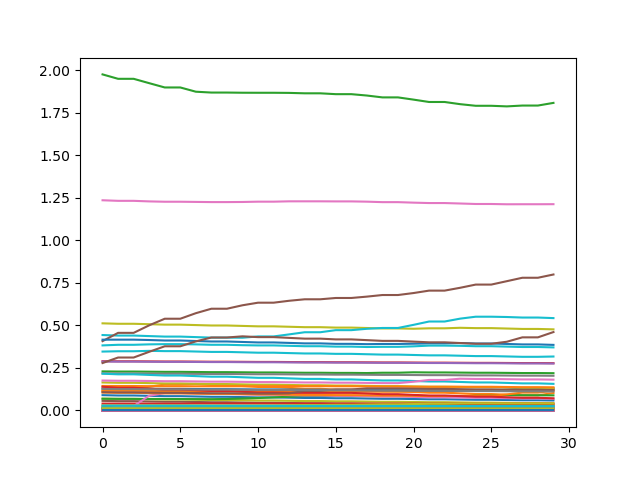

In [266]:
plt.close()
test=np.array(dfs2_per_sheet['All_Spindles']) #one average trace per unique unit 
plt.plot(test.T)
plt.show()

In [267]:
filenameOut = f'{directory}{NrSubtype}_SpindlesPFC_ABdetection_SpikeGrandAverageAB.xlsx'
excel_writer = pd.ExcelWriter(filenameOut)

Array=pd.DataFrame(dfs3_per_sheet['All_Spindles'])
ArrayUn=pd.DataFrame(dfs3_per_sheet['Uncoupled_Spindles'])
ArrayPre=pd.DataFrame(dfs3_per_sheet['Precoupled_Spindles'])
ArrayPost=pd.DataFrame(dfs3_per_sheet['Postcoupled_Spindles'])

Array.to_excel(excel_writer, sheet_name='All_Spindles', index=True, header=False)
ArrayUn.to_excel(excel_writer, sheet_name='Uncoupled_Spindles', index=True, header=False)
ArrayPre.to_excel(excel_writer, sheet_name='Precoupled_Spindles', index=True, header=False)
ArrayPost.to_excel(excel_writer, sheet_name='Postcoupled_Spindles', index=True, header=False)

# Save the Excel file
excel_writer.close()

In [268]:
filenameOut = f'{directory}{NrSubtype}_SpindlesPFC_ABdetection_HistSpikeGrandAverageAB.xlsx'
excel_writer = pd.ExcelWriter(filenameOut)

Array=np.array(dfs3_per_sheet['All_Spindles']) #one average trace per unique unit 
Array=Array.flatten()
counts, bins, _ = plt.hist(Array, bins=15) 
Array=pd.DataFrame(counts)
ArrayUn=np.array(dfs3_per_sheet['Uncoupled_Spindles']) #one average trace per unique unit 
ArrayUn=ArrayUn.flatten()
counts, bins, _ = plt.hist(ArrayUn, bins=15) 
ArrayUn=pd.DataFrame(counts)
ArrayPre=np.array(dfs3_per_sheet['Precoupled_Spindles']) #one average trace per unique unit 
ArrayPre=ArrayPre.flatten()
counts, bins, _ = plt.hist(ArrayPre, bins=15) 
ArrayPre=pd.DataFrame(counts)
ArrayPost=np.array(dfs3_per_sheet['Postcoupled_Spindles']) #one average trace per unique unit 
ArrayPost=ArrayPost.flatten()
counts, bins, _ = plt.hist(ArrayPost, bins=15) 
ArrayPost=pd.DataFrame(counts)
ArrayBins=pd.DataFrame(np.linspace(-0.5, 0.5, num=15))


Array.to_excel(excel_writer, sheet_name='All_Spindles', index=True, header=False)
ArrayUn.to_excel(excel_writer, sheet_name='Uncoupled_Spindles', index=True, header=False)
ArrayPre.to_excel(excel_writer, sheet_name='Precoupled_Spindles', index=True, header=False)
ArrayPost.to_excel(excel_writer, sheet_name='Postcoupled_Spindles', index=True, header=False)
ArrayBins.to_excel(excel_writer, sheet_name='Bins', index=True, header=False)

# Save the Excel file
excel_writer.close()